### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud

STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /home/pj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/pj/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Load Datasets
Integrating datasets into two data frames, True and False

In [3]:
dfFake = pd.read_csv('Data/archive/Fake.csv')
dfFake['label'] = 'Fake'
del dfFake['subject']
del dfFake['date']

dfFake

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,Fake
...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Fake
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Fake
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Fake
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Fake


In [4]:
dfTrue = pd.read_csv('Data/archive/True.csv')
dfTrue['label'] = 'True'
del dfTrue['subject']
del dfTrue['date']

dfTrue

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,True
...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,True
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",True
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,True
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,True


#### Modified data quality report
Helps determine what cleaning needs to be done

In [5]:
def quality_report(df):
  # Constructing a data quality report for the data
  cat_data = {'Feature': ['title', 'text', 'label'],
              'Count': df.count(),
              '% Missing': df.isnull().sum() * 100 / len(df),
              'Cardinality': df.apply(pd.Series.nunique),
              'Mode': [df.mode()['title'][0], 'null', df.mode()['label'][0]],
              'Mode Freq.': ['14', '769', '39644'],
              'Mode %': [14 / 63552 * 100, 769 / 64186 * 100 , 39644 / 64232 * 100],
      
              'Notes': ['', '', '']}
  cat_dqr_df = pd.DataFrame(cat_data)
  cat_dqr_df.reset_index(drop=True, inplace=True)

  return cat_dqr_df

In [6]:
print("Quality Report True Dataset")
quality_report(dfTrue).head()


Quality Report True Dataset


,Feature,Count,% Missing,Cardinality,Mode,Mode Freq.,Mode %,Notes
0,title,21417,0.0,20826,Factbox: Trump fills top jobs for his administ...,14,0.022029,
1,text,21417,0.0,21192,null,769,1.198081,
2,label,21417,0.0,1,True,39644,61.720015,


In [7]:
print("Quality Report Fake Dataset")
quality_report(dfFake).head()

Quality Report Fake Dataset


,Feature,Count,% Missing,Cardinality,Mode,Mode Freq.,Mode %,Notes
0,title,23481,0.0,17903,MEDIA IGNORES Time That Bill Clinton FIRED His...,14,0.022029,
1,text,23481,0.0,17455,null,769,1.198081,
2,label,23481,0.0,1,Fake,39644,61.720015,


In [8]:
# Build project using 20% 
dfTrue = dfTrue.head(int(0.20 * dfTrue.shape[0]))
dfFake = dfFake.head(int(0.20 * dfFake.shape[0]))

### Data Preprocessing
Removing stopwords, punctuation, and whitespace characters and Stemming

In [9]:
def clean_string(input):
  wl = WordNetLemmatizer()
  
  input = re.sub('[^a-zA-Z]', ' ', input)  # Remove special characters and spaces
  input = input.lower()                    # Lowercase all text

  input = input.split()  # Seperate into array of words
  input = [wl.lemmatize(word) for word in input if not word in STOPWORDS] # Remove stop words and replace word with stem
  input = ' '.join(input)  # Combine back into sentence             
  
  return input

def preprocess(df):
  copy = df.copy()
  copy.drop_duplicates(inplace = True) # Remove duplicates
  copy.dropna(axis=0, inplace = True)  # Remove rows with missing values
  cleanfunc = np.vectorize(clean_string)    # Use vectorization to increase speed
  copy['title'] = cleanfunc(copy['title'])  # Clean titles
  copy['text'] = cleanfunc(copy['text'])    # Clean text 
  return copy

In [10]:
dfTrue = preprocess(dfTrue)
dfFake = preprocess(dfFake)

In [11]:
dfTrue.head()

,title,text,label
0,u budget fight loom republican flip fiscal script,washington reuters head conservative republica...,True
1,u military accept transgender recruit monday p...,washington reuters transgender people allowed ...,True
2,senior u republican senator let mr mueller job,washington reuters special counsel investigati...,True
3,fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geor...,True
4,trump want postal service charge much amazon s...,seattle washington reuters president donald tr...,True


In [12]:
dfFake.head()

,title,text,label
0,donald trump sends embarrassing new year eve m...,donald trump wish american happy new year leav...,Fake
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,Fake
2,sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...,Fake
3,trump obsessed even obama name coded website i...,christmas day donald trump announced would bac...,Fake
4,pope francis called donald trump christmas speech,pope francis used annual christmas day message...,Fake


### Data Exploration & Visualization

#### Character Count in Title and Text

In [13]:
# Returns the char count for specified field
def getCharCount(df, field):
  return [len(text) for text in df[field].to_list()]

# Visualize char count of field in histogram
def histogram_char_count(df, count, field, label):
  plt.hist(count)
  plt.xlabel("Characters")
  plt.ylabel("News")
  plt.title(f'Character Count Distribution of {field} in {label} News')
  plt.show()

def plot_avg_char_count(dfTrue, dfFake, field, countTrue, countFake):
  avg_count_true = int(np.average(countTrue))
  avg_count_fake = int(np.mean(countFake))

  df = pd.DataFrame([['True', int(avg_count_true)], ['Fake', int(avg_count_fake)]], columns=['News', 'Characters'])
  df.plot(x='News', y='Characters', kind='bar', width=0.3, xlabel='News', legend=False,
                    ylabel='Characters', title=f'Average Character Count of {field}')  
  plt.xticks(rotation=0)
  plt.show()
  
# Calculate and visualize character count statistics
def character_stats(dfTrue, dfFake, field):
  print(f"Character Count Distribution of {field}")
  true_char_count= getCharCount(dfTrue, field)
  histogram_char_count(dfTrue, true_char_count, field, "True")

  fake_char_count = getCharCount(dfFake, field)
  histogram_char_count(dfFake, fake_char_count, field, "Fake") 

  print(f"Average Count of {field}")
  plot_avg_char_count(dfTrue, dfFake, field, true_char_count, fake_char_count)

Character Count Distribution of title


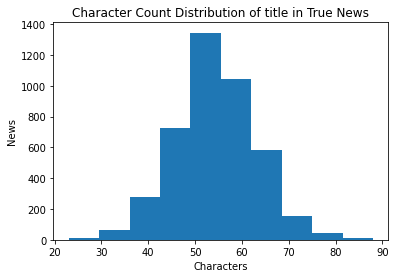

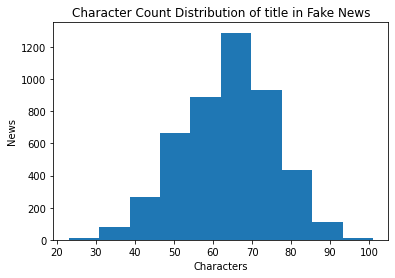

Average Count of title


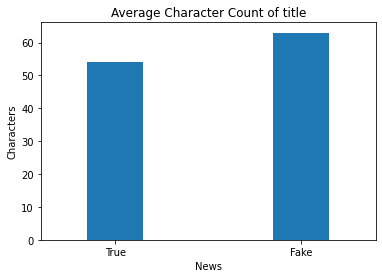

Character Count Distribution of text


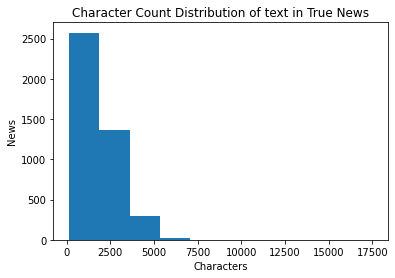

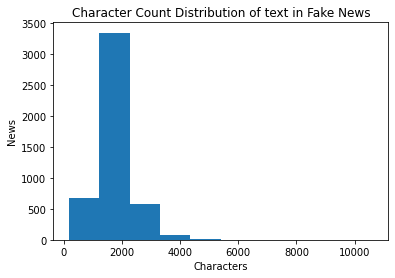

Average Count of text


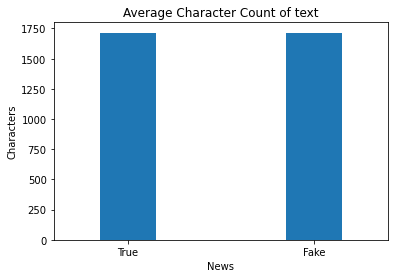

In [14]:
character_stats(dfTrue, dfFake, 'title')
character_stats(dfTrue, dfFake, 'text')

#### Word count in Title and Text

In [15]:
vectorizer = CountVectorizer()

# Returns the char count for specified field
def getWordCount(df, field):
  counts = []
  for text in df[field].to_list():
    text_count = np.sum(vectorizer.fit_transform([text]).toarray())
    counts.append(text_count)
  return counts

# Visualize word count of field in histogram
def histogram_word_count(df, count, field, label):
  plt.hist(count)
  plt.xlabel("Words")
  plt.ylabel("News")
  plt.title(f'Word Count Distribution of {field} in {label} News')
  plt.show()
  
def plot_avg_word_count(dfTrue, dfFake, field, countTrue, countFake):
  avg_count_true = int(np.average(countTrue))
  avg_count_fake = int(np.mean(countFake))

  df = pd.DataFrame([['True', int(avg_count_true)], ['Fake', int(avg_count_fake)]], columns=['News', 'Words'])
  df.plot(x='News', y='Words', kind='bar', width=0.3, xlabel='News', legend=False,
                    ylabel='Words', title=f'Average Word Count of {field}')  
  plt.xticks(rotation=0)
  plt.show()
  
# Calculate and visualize word count statistics
def word_stats(dfTrue, dfFake, field):
  print(f"Word Count Distribution of {field}")
  true_word_count= getWordCount(dfTrue, field)
  histogram_word_count(dfTrue, true_word_count, field, "True")

  fake_word_count = getWordCount(dfFake, field)
  histogram_word_count(dfFake, fake_word_count, field, "Fake") 

  print(f"Average count of {field}")
  plot_avg_word_count(dfTrue, dfFake, field, true_word_count, fake_word_count)


Word Count Distribution of title


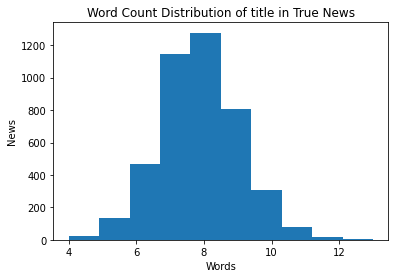

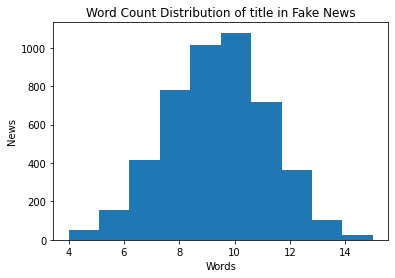

Average count of title


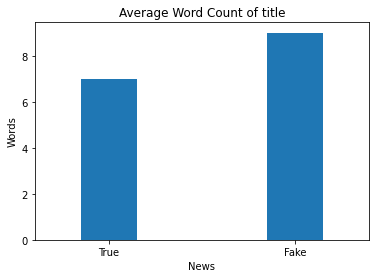

In [16]:
word_stats(dfTrue, dfFake, 'title')

Word Count Distribution of text


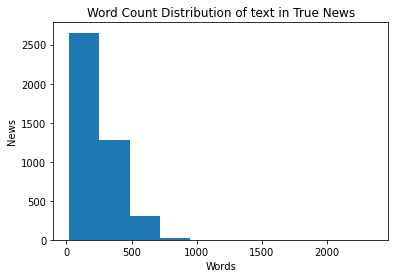

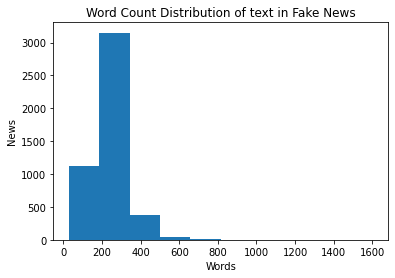

Average count of text


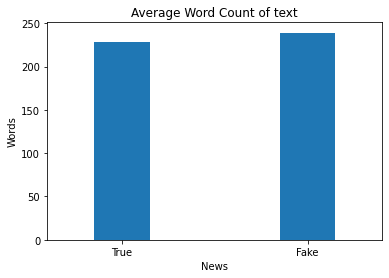

In [17]:
word_stats(dfTrue, dfFake, 'text')

#### Visualize Frequent Words with WordCloud

In [18]:
def generateWordCloud(df, feature):
  wordcloud = WordCloud(max_words=50).generate(' '.join(df[feature].tolist()))
  # plot the WordCloud                      
  plt.figure(figsize = (10, 10), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  
  plt.show()


WordCloud for Fake News Titles


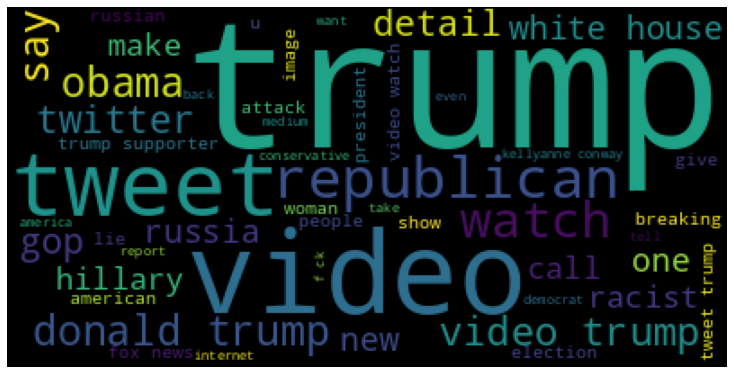

WordCloud for Fake News Text


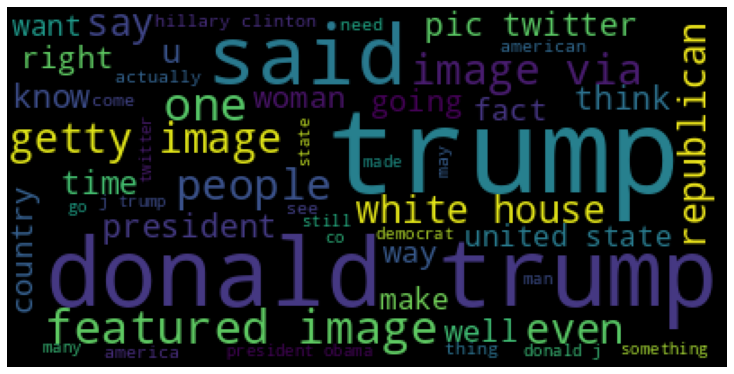

In [19]:
# Visualize most significant words for fake news
print("WordCloud for Fake News Titles")
generateWordCloud(dfFake, 'title')
print("WordCloud for Fake News Text")
generateWordCloud(dfFake, 'text')

WordCloud for True News Titles


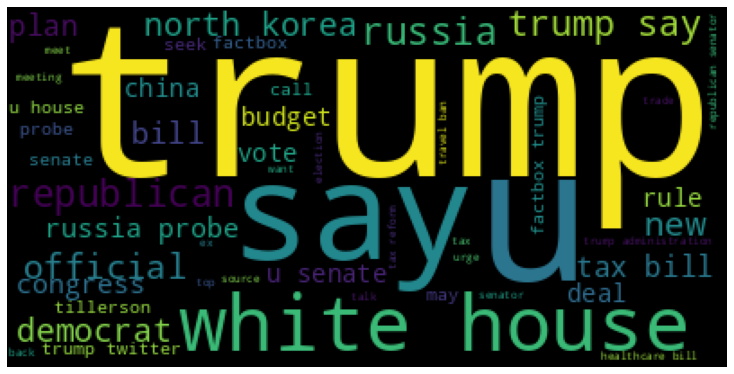

WordCloud for True News Text


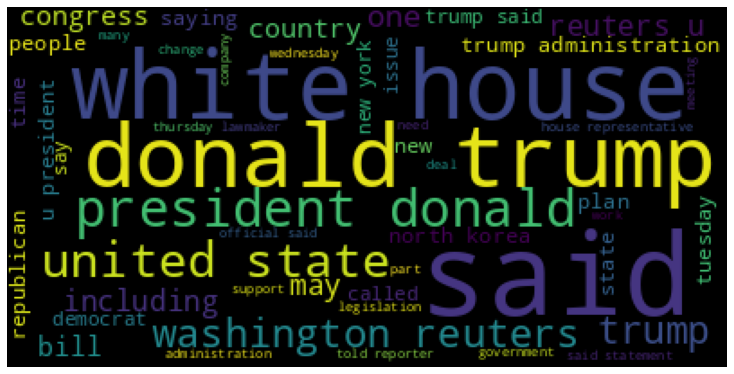

In [20]:
# Visualize most significant words for true news
print("WordCloud for True News Titles")
generateWordCloud(dfTrue, 'title')
print("WordCloud for True News Text")
generateWordCloud(dfTrue, 'text')

#### Sentiment Analysis

In [29]:
def plot_polarity(field):
  true_polarities = dfTrue[field].map(lambda text: TextBlob(text).sentiment.polarity)
  fake_polarities = dfFake[field].map(lambda text: TextBlob(text).sentiment.polarity)

  avg_true_polarity = np.average(true_polarities)
  avg_fake_polarity = np.average(fake_polarities)

  print(f'Average polarity of True {field}: {avg_true_polarity:.4f}')
  print(f'Average polarity of Fake {field}: {avg_fake_polarity:.4f}')


  df = pd.DataFrame([['True', avg_true_polarity], ['Fake', avg_fake_polarity]], columns=['News', 'Polarity'])
  df.plot(x='News', y='Polarity', kind='bar', width=0.3, xlabel='News', legend=False,
                    ylabel='Words', title=f'Average Polarity of {field}')  
  plt.xticks(rotation=0)
  plt.show()



def plot_subjectivity(field):
  true_subjectivity = dfTrue[field].map(lambda text: TextBlob(text).sentiment.subjectivity)
  fake_subjectivity = dfFake[field].map(lambda text: TextBlob(text).sentiment.subjectivity)

  avg_true_subjectivity = np.average(true_subjectivity)
  avg_fake_subjectivity = np.average(fake_subjectivity)

  print(f'Average subjectivity of True {field}: {avg_true_subjectivity:.4f}')
  print(f'Average subjectivity of Fake {field}: {avg_fake_subjectivity:.4f}')


  df = pd.DataFrame([['True', avg_true_subjectivity], ['Fake', avg_fake_subjectivity]], columns=['News', 'Subjectivity'])
  df.plot(x='News', y='Subjectivity', kind='bar', width=0.3, xlabel='News', legend=False,
                    ylabel='Words', title=f'Average Subjectivity of {field}')  
  plt.xticks(rotation=0)
  plt.show()

##### Average Polarity of Titles

Average polarity of True title: 0.0281
Average polarity of Fake title: -0.0111


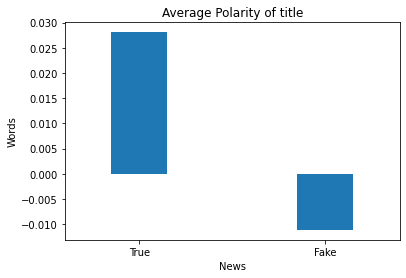

In [30]:
plot_polarity('title')

##### Average Polarity of Texts

Average polarity of True text: 0.0561
Average polarity of Fake text: 0.0373


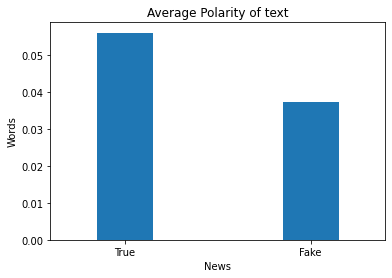

In [31]:
plot_polarity('text')

##### Average Subjectivity of Titles

Average subjectivity of True title: 0.1821
Average subjectivity of Fake title: 0.3771


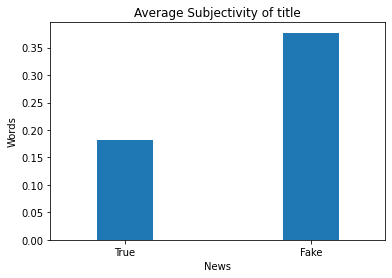

In [32]:
plot_subjectivity('title')

##### Average Subjectivity of Texts

Average subjectivity of True text: 0.3578
Average subjectivity of Fake text: 0.4590


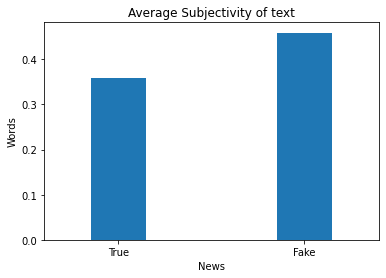

In [33]:
plot_subjectivity('text')

### Classifications

#### Combine Text and Title

In [50]:
def combine_text_title(df, label):
  newdf = pd.DataFrame()
  content = zip(df['title'].to_list(), df['text'].to_list())
  newdf['content'] = [str(title + text) for title, text in content]
  newdf['label'] = [ label for i in range(df.shape[0]) ]  # Add label
  return newdf

In [51]:
dfFake = combine_text_title(dfFake, 'Fake')
dfTrue = combine_text_title(dfTrue, 'True')

#### Create Train and Test Sets

In [52]:
dataset = pd.concat([dfTrue, dfFake]) # Combine True and Fake datasets 
train_set, test_set = train_test_split(dataset, train_size=0.7)
train_set.reset_index(drop=True)
test_set.reset_index(drop=True)

,content,label
0,seth meyers summed monday event perfectly vide...,Fake
1,trump give huge f k state hillary taking liter...,Fake
2,elderly california man savaged gop congressman...,Fake
3,u diversity visa program spotlight new york at...,True
4,republican secretly terrified trump already ha...,Fake
...,...,...
2682,trump announces push speed desperately needed ...,True
2683,white house proposes billion cut agriculture t...,True
2684,congress demand white house turn alleged comey...,Fake
2685,trump say record conversation former fbi direc...,True


#### Create Different Term Vector Models


In [53]:
# Create specified vector model using vectorizer
def create_vector_model(vectorizer, train_set, test_set):
  cpy_train_set = train_set.copy()
  cpy_test_set = test_set.copy()

  train_labels = cpy_train_set['label']
  test_labels = cpy_test_set['label']

  le = LabelEncoder()
  le.fit(['Fake', "True"])
  train_labels = le.fit_transform(train_labels)
  test_labels = le.fit_transform(test_labels)

  cpy_train_set.drop(columns='label', inplace=True)
  cpy_test_set.drop(columns='label', inplace=True)



  cpy_train_set = vectorizer.fit_transform(cpy_train_set['content'])
  cpy_test_set = vectorizer.transform(cpy_test_set['content'])


  return cpy_train_set, train_labels, cpy_test_set, test_labels

Simple Count Vector Model

In [54]:
# Create simple count vector model of dataset
count_v = CountVectorizer()
count_vector_model = create_vector_model(count_v, train_set, test_set)

cv_train_set = count_vector_model[0]
cv_test_set = count_vector_model[2]


TF-IDF Vector Model

In [55]:
# Create TF-IDF vector model of dataset
tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1,3))  # Get 5000 most significant words/n-grams
tfidf_vector_model = create_vector_model(tfidf_v, train_set, test_set)

In [56]:
tv_train_set, tv_train_labels, tv_test_set, tv_test_labels = tfidf_vector_model


#### Classfication Methods

In [57]:
# Apply specified classification method and provide performance metrics
def classify_pipeline(method, vector_model, wm = False, arr = False):
  train_set, train_labels, test_set, test_labels = vector_model # Get sets and labels from model
  
  if arr:
    train_set = train_set.toarray()
    test_set = test_set.toarray()

  scl = StandardScaler(with_mean=False).fit(train_set)
  model = method.fit(train_set, train_labels)
  
  pipeline = Pipeline([('scl', scl), ('model', model)])  # Pipeline standardize data then use given classification method
  
  predictions = pipeline.predict(test_set)

  cr = classification_report(test_labels, predictions)
  accuracy = accuracy_score(test_labels, predictions)
  conf_matrix = ConfusionMatrixDisplay.from_predictions(test_labels, predictions)

  print(cr)
  print(f'Accuracy: {accuracy*100:.3f} %')
  print(f"Confusion Matrix:")
  conf_matrix
  
  return pipeline.named_steps['model']

#### Logistic Regression


Count Vector Model

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1459
           1       1.00      0.98      0.99      1228

    accuracy                           0.99      2687
   macro avg       0.99      0.99      0.99      2687
weighted avg       0.99      0.99      0.99      2687

Accuracy: 98.884 %
Confusion Matrix:


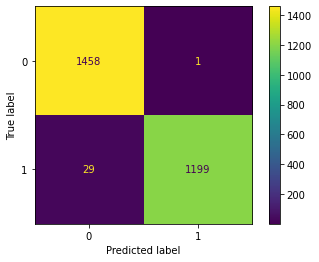

In [58]:
LR_CV = classify_pipeline(LogisticRegression(), count_vector_model)

TF-IDF Vector Model

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1459
           1       1.00      0.99      1.00      1228

    accuracy                           1.00      2687
   macro avg       1.00      1.00      1.00      2687
weighted avg       1.00      1.00      1.00      2687

Accuracy: 99.553 %
Confusion Matrix:


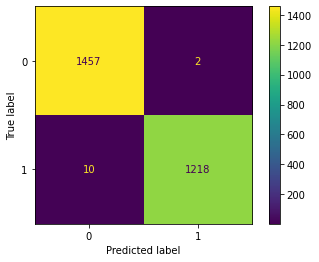

In [59]:
LR_TV = classify_pipeline(LogisticRegression(), tfidf_vector_model)

#### Decision Tree Classifier

Count Vector Model

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1459
           1       0.98      1.00      0.99      1228

    accuracy                           0.99      2687
   macro avg       0.99      0.99      0.99      2687
weighted avg       0.99      0.99      0.99      2687

Accuracy: 99.144 %
Confusion Matrix:


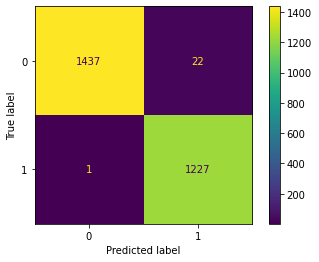

In [60]:
DT_CV = classify_pipeline(DecisionTreeClassifier(max_depth=5), count_vector_model)

TF-IDF Vector Model

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1459
           1       0.96      0.78      0.86      1228

    accuracy                           0.89      2687
   macro avg       0.90      0.88      0.88      2687
weighted avg       0.90      0.89      0.88      2687

Accuracy: 88.537 %
Confusion Matrix:


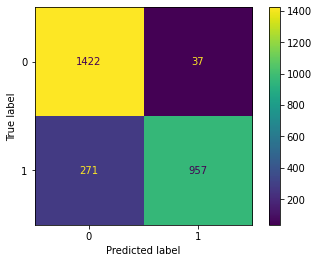

In [61]:
DT_TV = classify_pipeline(DecisionTreeClassifier(), tfidf_vector_model, arr=True)

#### Support Vector Machines Classifier

Count Vector Model

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1459
           1       1.00      0.96      0.98      1228

    accuracy                           0.98      2687
   macro avg       0.98      0.98      0.98      2687
weighted avg       0.98      0.98      0.98      2687

Accuracy: 98.176 %
Confusion Matrix:


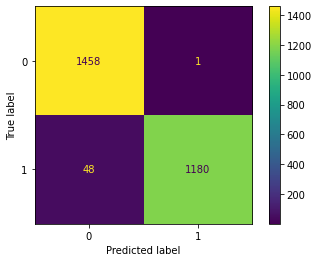

In [62]:

SVM_CV = classify_pipeline(SVC(kernel="linear"), count_vector_model)

TF-IDF Vector Model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1459
           1       1.00      1.00      1.00      1228

    accuracy                           1.00      2687
   macro avg       1.00      1.00      1.00      2687
weighted avg       1.00      1.00      1.00      2687

Accuracy: 99.739 %
Confusion Matrix:


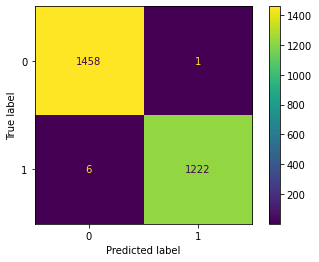

In [63]:
SVM_TV = classify_pipeline(SVC(kernel="linear"), tfidf_vector_model)

#### Naive Bayes Classifier

Count Vector Model

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1459
           1       0.96      0.94      0.95      1228

    accuracy                           0.96      2687
   macro avg       0.96      0.95      0.96      2687
weighted avg       0.96      0.96      0.96      2687

Accuracy: 95.571 %
Confusion Matrix:


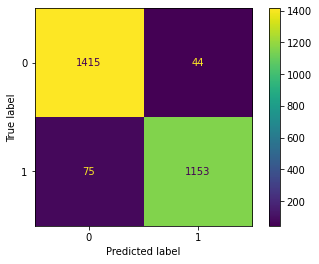

In [64]:
NB_CV = classify_pipeline(MultinomialNB(), count_vector_model)

TF-IDF Vector Model

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1459
           1       0.98      0.97      0.98      1228

    accuracy                           0.98      2687
   macro avg       0.98      0.98      0.98      2687
weighted avg       0.98      0.98      0.98      2687

Accuracy: 98.028 %
Confusion Matrix:


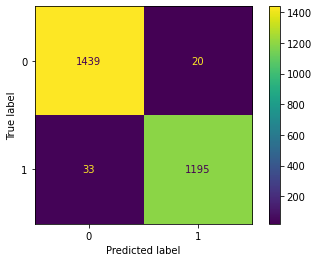

In [65]:
NB_TV = classify_pipeline(MultinomialNB(), tfidf_vector_model)

# Cross Validation

Prepare Data

In [66]:
cpy = dataset.copy()
le = LabelEncoder()
labels = le.fit_transform(cpy['label'])
cpy.drop(columns='label', inplace=True)
df = tfidf_v.transform(cpy['content'])

Perform Cross Validation

In [67]:
lr_cross_score = np.average(cross_val_score(LR_TV, df, labels))
svm_cross_score = np.average(cross_val_score(SVM_TV, df, labels))

In [68]:
print(f"Log Reg Cross Validation Score: {lr_cross_score*100:.3f}%")
print(f"SVM Cross Validation Score: {svm_cross_score*100:.3f}%")

Log Reg Cross Validation Score: 99.006%
SVM Cross Validation Score: 99.687%
